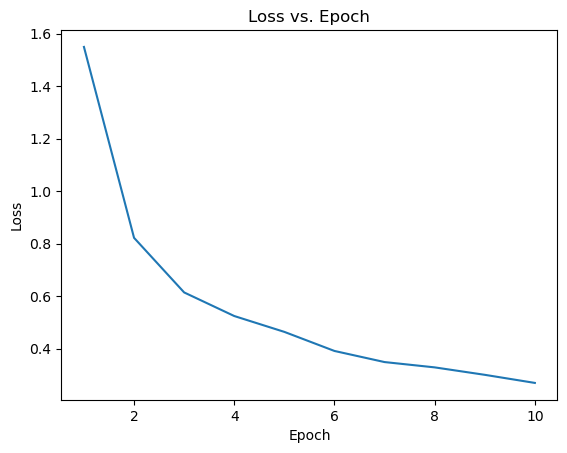

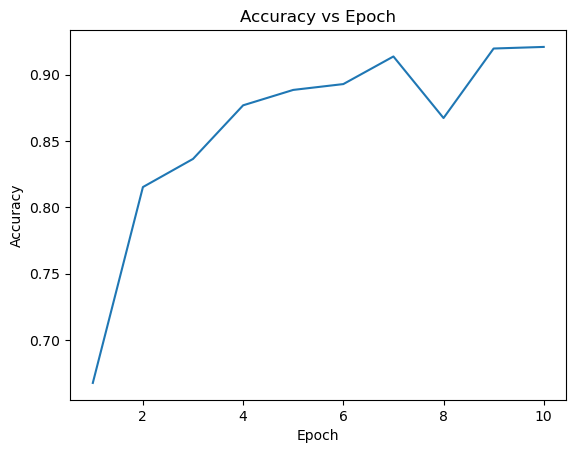

In [1]:
import os
from PIL import Image
import numpy as np
import random as rd
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

class FCLayer():
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) -0.5
        self.bias = np.random.rand(1, output_size) -0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationLayer():
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def softmax_prime(x):
    s = softmax(x)
    return s * (1 - s)

# loss function and its derivative
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

def categorical_crossentropy_prime(y_true, y_pred):
    return y_pred - y_true

# class for Neural Network
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, learning_rate):
        global total_loss
        
        # forward propagation
        output = x_train
        for layer in self.layers:
            output = layer.forward_propagation(output)

        err = self.loss(y_train, output)
        # Calculating total; error for each epoch
        total_loss+=err

        # backward propagation
        error = self.loss_prime(y_train, output)
        for layer in reversed(self.layers):
            error = layer.backward_propagation(error, learning_rate)

master_names = []  # Initialize an empty list

# Adding name sof all images into master_names array
for i in range(10):
    subdirectory_path = '/kaggle/input/spider-spml-sop/trainingSet/trainingSet/{}'.format(i)
    # Loop over all directories in the current directory
    for dirpath, dirnames, filenames in os.walk(subdirectory_path):
        # Check if directory contains images
        if any(filename.endswith('.jpg') or filename.endswith('.png') for filename in filenames):
            # Sort images by name
            images = sorted([filename for filename in filenames if filename.endswith('.jpg') or filename.endswith('.png')])

            # Keep only the first 250 images
            images_to_remove = images[250:]
            # Remove the extra images
            for image in images_to_remove:
                os.remove(os.path.join(dirpath, image))
    
    for j in images:
        master_names.append([j,i])   # Storing what the image represents in numbers 0-9 with its name in the array

# Shuffling array to train network accurately
rd.shuffle(master_names)


# network
net = Network()
net.add(FCLayer(784, 16))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(16, 8))
net.add(ActivationLayer(relu, relu_prime))
net.add(FCLayer(8, 10))
net.add(ActivationLayer(softmax, softmax_prime))

epochs=10
loss_values = []  # List to store the loss values
accuracy_values = []  # List to store accuracy values for each epoch
true_labels = [] # List to store all the numbers the images in the master_names array represents 

for names in master_names:
    true_labels.append(names[1])

for _ in range(epochs):

    total_loss = 0
    count_pred = 0

    for i in range(2500):
        img = Image.open('/kaggle/input/spider-spml-sop/trainingSet/trainingSet/{}/{}'.format(master_names[i][1],master_names[i][0])).convert('L')
        numpydata = np.asarray(img)
        numpydata = numpydata.flatten()
        numpydata = numpydata/255
        numpydata = numpydata.tolist()
        numpydata = np.array([numpydata])

        y_train=np.array([[0,0,0,0,0,0,0,0,0,0]])
        y_train[0][master_names[i][1]]=1


        net.use(categorical_crossentropy, categorical_crossentropy_prime)
        net.fit(numpydata, y_train, learning_rate=0.1)
    
    average_loss = total_loss / 2500
    loss_values.append(average_loss)
    
    # To predict the output of each image in training data set to calculate accuracy
    for i in range(2500):
        img_pred = Image.open('/kaggle/input/spider-spml-sop/trainingSet/trainingSet/{}/{}'.format(master_names[i][1],master_names[i][0])).convert('L')
        numpydata_pred = np.asarray(img_pred)
        numpydata_pred = numpydata_pred.flatten()
        numpydata_pred = numpydata_pred/255
        numpydata_pred = numpydata_pred.tolist()
        numpydata_pred = np.array([numpydata_pred])

        out_pred = net.predict(numpydata_pred)
        n_pred = np.argmax(out_pred)
        
        if n_pred == true_labels[i]:
            count_pred+=1
    
    accuracy = count_pred/2500
    accuracy_values.append(accuracy)

# test

filename = "test.csv"
fields = ["file_name","pred"]
rows=[]

# Loop over all directories in the current directory
for dirpath, dirnames, filenames in os.walk("/kaggle/input/spider-spml-sop/test_set/test"):
    # Check if directory contains images
    if any(filename.endswith('.jpg') or filename.endswith('.png') for filename in filenames):
        # Sort images by name
        images_test = sorted([filename for filename in filenames if filename.endswith('.jpg') or filename.endswith('.png')])


# Checks the trained neural network against test data set
for img in images_test:
    img_check = Image.open('/kaggle/input/spider-spml-sop/test_set/test/{}'.format(img)).convert('L')
    numpydata_check = np.asarray(img_check)
    numpydata_check = numpydata_check.flatten()
    numpydata_check = numpydata_check/255
    numpydata_check = numpydata_check.tolist()
    numpydata_check = np.array([numpydata_check])
    
    out = net.predict(numpydata_check)
    n = np.argmax(out)
    rows.append([img,n])

# Writing to CSV file
df = pd.DataFrame(rows, columns=fields)
df.to_csv(filename, index=False)

# Plotting the loss vs. epoch graph
plt.plot(range(1, epochs+1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()


# Plotting accuracy vs epoch graph
plt.plot(range(1, epochs+1), accuracy_values)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.show()